# Analise de dados sobre o filme starwas

## importação das bibliotecas

In [12]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Funções personalizadas

In [13]:
def sentiment_analysis(texto):
    analyse = TextBlob(texto)
    if analyse.sentiment.polarity > 0:
        return "positive"
    elif analyse.sentiment.polarity < 0:
        return "negative"
    else:
        return "neutral"


def clean_word(word):
    word = word.lower().strip(string.punctuation + "’“”‘")
    # Remove qualquer pontuação restante (incluindo no meio da palavra)
    word = ''.join([char for char in word if char not in string.punctuation])
    return word


## Importar dataset e dados gerais dele

In [14]:
df = pd.read_csv("datasets/SW_EpisodeIV.csv")
personagens = df["character"].unique()
n_personagens = len(personagens)

print(personagens, n_personagens)

['THREEPIO' 'LUKE' 'IMPERIAL OFFICER' 'VADER' 'REBEL OFFICER' 'TROOPER'
 'CHIEF PILOT' 'CAPTAIN' 'WOMAN' 'FIXER' 'CAMIE' 'BIGGS' 'DEAK' 'LEIA'
 'COMMANDER' 'SECOND OFFICER' 'FIRST TROOPER' 'SECOND TROOPER' 'BERU'
 'OWEN' 'AUNT BERU' 'BEN' 'TAGGE' 'MOTTI' 'TARKIN' 'BARTENDER' 'CREATURE'
 'HUMAN' 'HAN' 'GREEDO' 'JABBA' 'OFFICER CASS'
 'VOICE OVER DEATH STAR INTERCOM' 'OFFICER' 'VOICE' 'GANTRY OFFICER'
 'INTERCOM VOICE' 'TROOPER VOICE' 'FIRST OFFICER' 'WILLARD'
 'DEATH STAR INTERCOM VOICE' 'DODONNA' 'GOLD LEADER' 'WEDGE' 'MAN'
 'RED LEADER' 'CHIEF' 'MASSASSI INTERCOM VOICE' 'RED TEN' 'RED SEVEN'
 'PORKINS' 'RED NINE' 'RED ELEVEN' 'ASTRO-OFFICER' 'CONTROL OFFICER'
 'GOLD FIVE' 'GOLD TWO' 'WINGMAN' 'BASE VOICE' 'TECHNICIAN'] 60


## Núvem de palavras mais faladas no filme

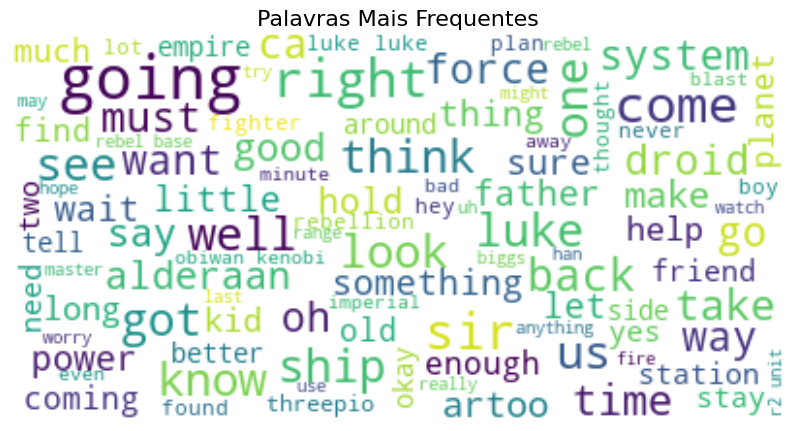

In [15]:
stop_words = set(stopwords.words("english"))
stop_words.update(["you","it", "nt"])


# Processamento robusto com tratamento de erros
words = []
for sentence in df["speech"]:
    try:
        tokens = word_tokenize(str(sentence))  # Garante que seja string
        for word in tokens:
            cleaned = clean_word(word)
            if cleaned and cleaned not in stop_words:
                words.append(cleaned)
    except Exception as e:
        print(f"Erro ao processar: {sentence}\nErro: {e}")


text = " ".join(words)

# Criar a nuvem de palavras
wordcloud = WordCloud(background_color="white", max_font_size=32, min_font_size=8, max_words=100).generate(text)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove eixos
plt.title("Palavras Mais Frequentes", fontsize=16)
plt.show()


## Palavras mais faladas

<Axes: >

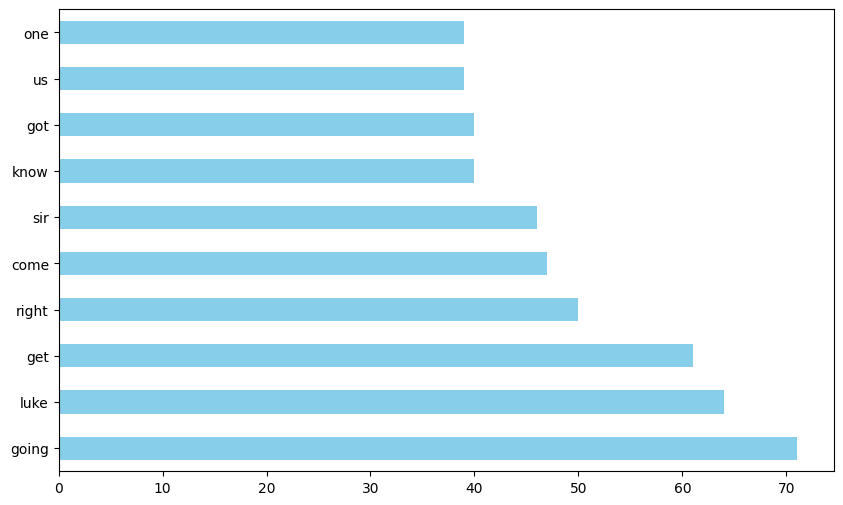

In [16]:
pd.Series(words).value_counts().head(10).plot(kind="barh", figsize=(10, 6), color="skyblue")

O filme teve `n_personagens`os quais são: `personagens`


## top 10 personagens mais participativos no filme

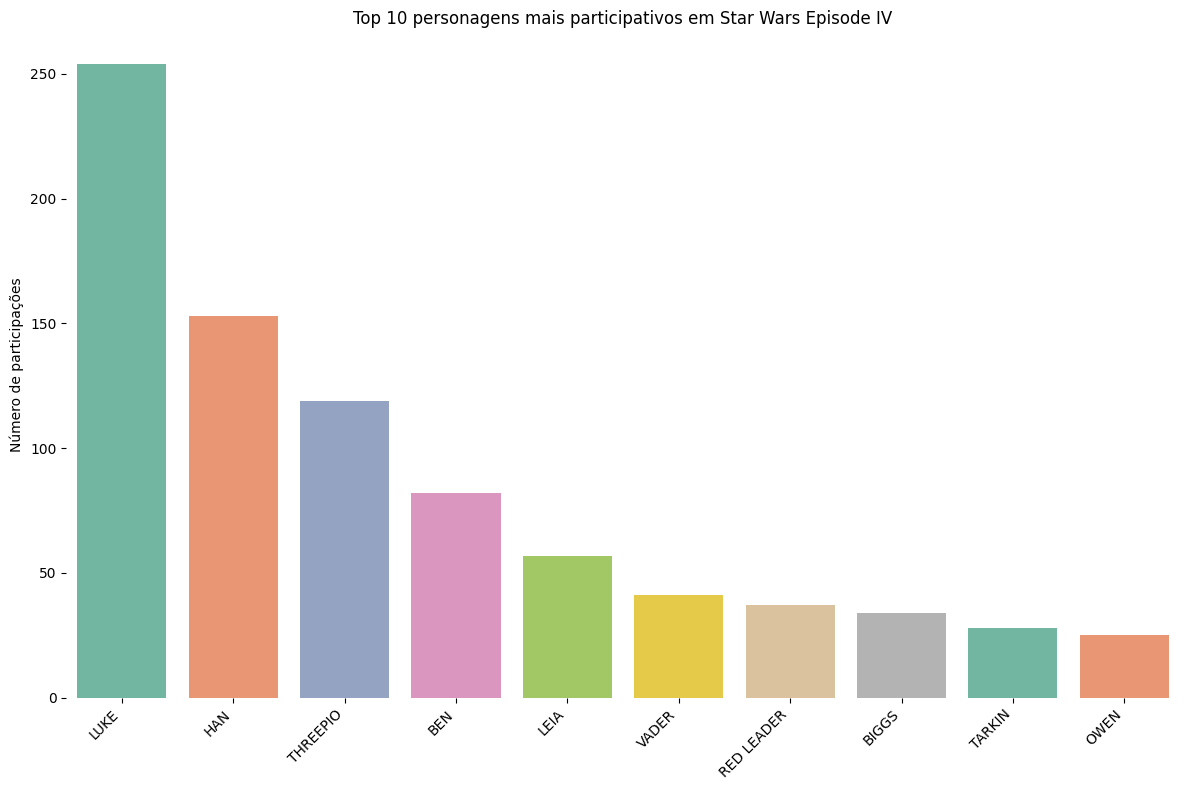

In [17]:
df_plot = df.groupby("character").count().sort_values("speech", ascending=False)
top_10 = df_plot.head(10)

total_participation = df_plot["speech"].sum().item()
top_10_participation = top_10.sum().item()
other_participation = total_participation - top_10_participation

top_10_percentage_participation = round(top_10_participation/total_participation,2)
others_percentage_participation = round(1 -top_10_percentage_participation, 2) 


plt.figure(figsize=(12,8))
sns.barplot(data=top_10, x="character", y="speech", hue="character", dodge=False, palette="Set2")
plt.title("Top 10 personagens mais participativos em Star Wars Episode IV")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.box(False)
plt.ylabel("Número de participações")
plt.tight_layout()
plt.show()

In [18]:
df_top_10 = df[df["character"].isin(top_10.reset_index()["character"])].copy()
df_top_10["polarity"] = df_top_10["speech"].apply(lambda text: 
TextBlob(text).sentiment.polarity)
df_top_10["subjectivity"] = df_top_10["speech"].apply(lambda text: TextBlob(text).sentiment.subjectivity)
df_top_10_plot_polarity = df_top_10.groupby("character").agg(polarity_mean = ("polarity", "mean"), polarity_sd = ("polarity", "std"), subjectivity_mean = ("subjectivity", "mean"), subjectivity_sd = ("subjectivity", "std")).reset_index()
df_top_10_plot_polarity["polarity_sd"] = df_top_10_plot_polarity["polarity_sd"].fillna(0)
df_top_10_plot_polarity["subjectivity_sd"] = df_top_10_plot_polarity["subjectivity_sd"].fillna(0.5)

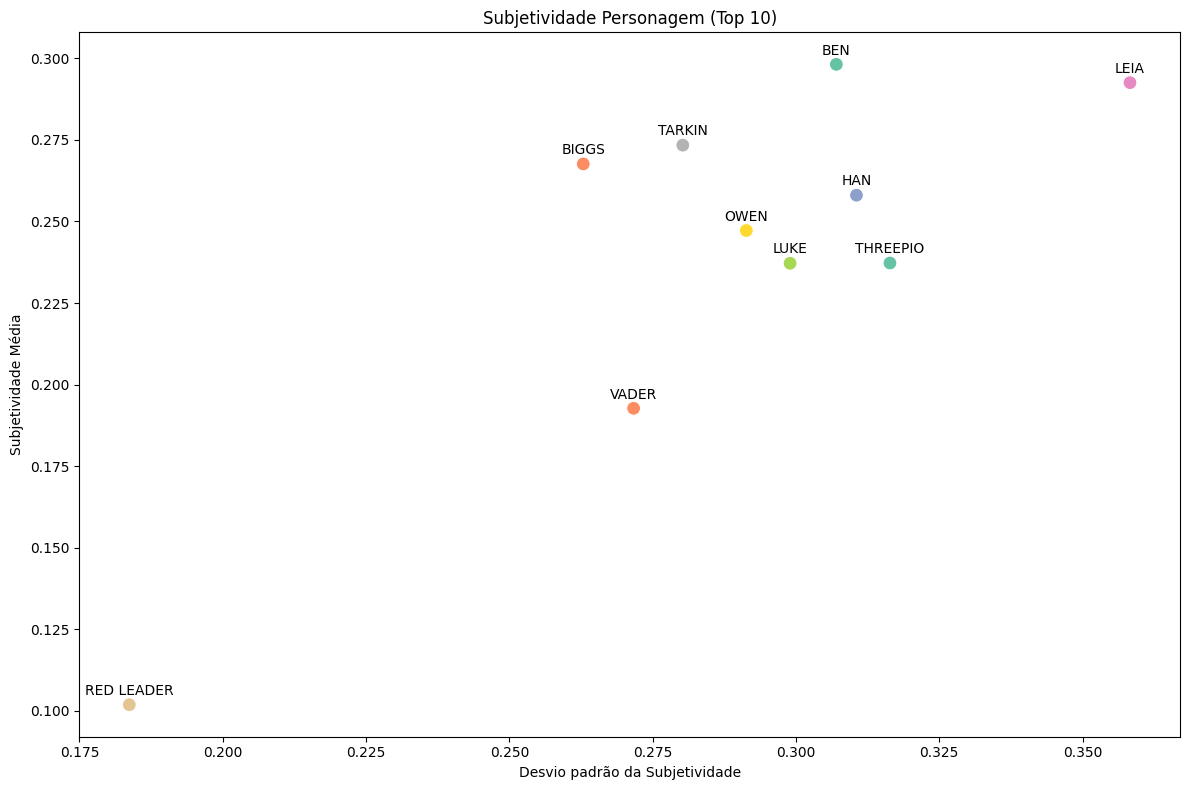

In [19]:
# Criar o gráfico de dispersão
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=df_top_10_plot_polarity,
    x="subjectivity_sd",
    y="subjectivity_mean",
    hue="character",
    palette="Set2",
    s=100  # Tamanho dos pontos
)

for _, row in df_top_10_plot_polarity.iterrows():
    ax.text(row["subjectivity_sd"], row["subjectivity_mean"] + .003, row["character"], fontsize=10, ha="center")

# Melhorar a visualização
plt.title("Subjetividade Personagem (Top 10)")
plt.xlabel("Desvio padrão da Subjetividade")
plt.ylabel("Subjetividade Média")
plt.legend(title="Personagem", bbox_to_anchor=(1.05, 1))  # Mover a legenda para fora
plt.legend().set_visible(False)  # Mover a legenda para fora

plt.tight_layout()  # Ajustar layout para evitar cortes
plt.show()

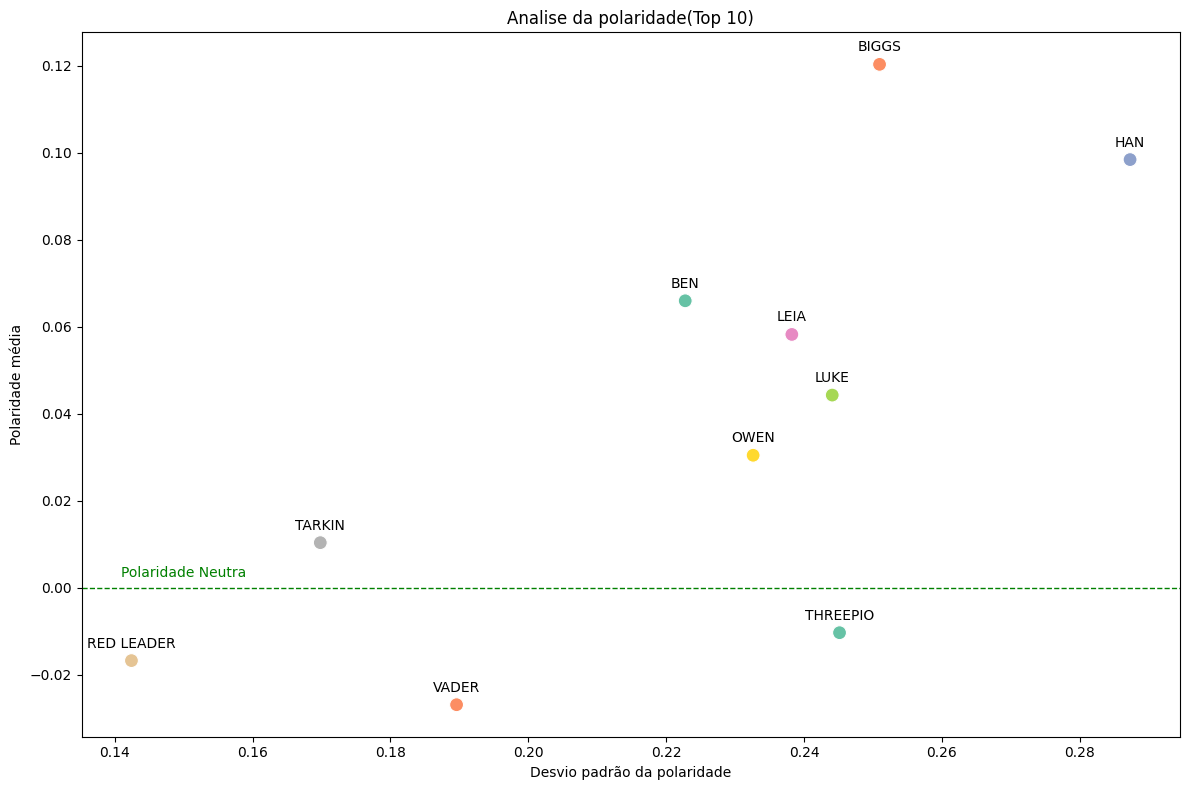

In [20]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=df_top_10_plot_polarity, x="polarity_sd", y="polarity_mean", hue="character", palette="Set2", s=100)

for _, row in df_top_10_plot_polarity.iterrows():
    ax.text(x = row["polarity_sd"], y = row["polarity_mean"] + .003, s = row["character"], fontsize=10, ha="center")

ax.text(x = 0.15, y = 0.0025,  s = "Polaridade Neutra", fontsize=10, ha="center", color="green")
plt.axhline(0, color="green", lw=1, ls="--", label="Polaridade Neutra")
plt.title("Analise da polaridade(Top 10)")
plt.xlabel("Desvio padrão da polaridade")
plt.ylabel("Polaridade média")
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

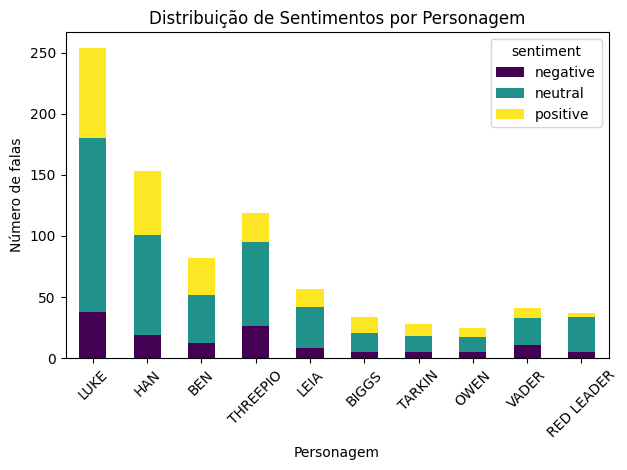

In [31]:
df_top_10["sentiment"] = df_top_10["speech"].apply(sentiment_analysis)

# Contar sentimentos por personagem
sentiment_counts = df_top_10.groupby(["character", "sentiment"]).size().unstack().fillna(0)
plt.figure(figsize=(12, 6))
sentiment_counts.sort_values(by="positive", ascending=False).plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Distribuição de Sentimentos por Personagem")
plt.xlabel("Personagem")
plt.ylabel("Número de falas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
